Running an AutoML regression (H2O) on the data of prices of cars. This notebook is intended for running on Google Colab:
https://colab.research.google.com/

The performance is significantly better, than that of the linear regression. It can be further improved by increasing the time of computation.

In [1]:
!pip install h2o

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

In [3]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()
# deploys h2o on the cluster.

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp3sci4zk_
  JVM stdout: /tmp/tmp3sci4zk_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp3sci4zk_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_unknownUser_pk9aqq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Reading the data.

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/Alexandre-aksenov/predict-car-prices-using-H2O-tpot/main/ToyotaCorolla.csv')

print(data.shape)  # (1436, 10)

(1436, 10)


In [5]:
data.head()

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight
0,13500,23,46986,Diesel,90,1,0,2000,3,1165
1,13750,23,72937,Diesel,90,1,0,2000,3,1165
2,13950,24,41711,Diesel,90,1,0,2000,3,1165
3,14950,26,48000,Diesel,90,0,0,2000,3,1165
4,13750,30,38500,Diesel,90,0,0,2000,3,1170


The data of prices of Toyota is loaded successfully.

Now tackling the regression problem using the package H2O.

array([[<Axes: title={'center': 'discr_price'}>]], dtype=object)

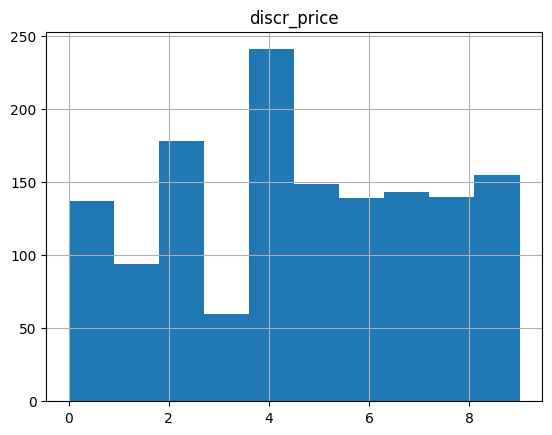

In [16]:
target = [data.columns[0]]

# train-test split. 
# sklearn is used for stratified subdivision, making sure that the subdivision is the same 
# than for the linear regression.

# N.B. Possile improvement.
# This stratified subdivision in case of continuous variable can be transformed into a function,
# or it would be even better if this function can be found.

# Prototype.
# data, params of KBinsDiscretizer , params of train_test_split
# -> data_train, data_test

price_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal')
#  default strategy : 'quantile'

y_discretized = price_discretizer.fit_transform(data[target])
discrete_target = ['discr_price']

data[discrete_target] = y_discretized

data[discrete_target].hist()

# the extra column 'discr_price' should be removed after train-test split.


In [17]:
data_train, data_test = train_test_split(data, test_size=0.2, stratify=data['discr_price'], random_state=42)

# removing the extra column 'discr_price'.
data_train.drop(columns=discrete_target, inplace=True)
data_test.drop(columns=discrete_target, inplace=True)

# end of the function

print(data_train.shape)  # (1148, 10)
print(data_test.shape)   #  (288, 10)

(1148, 11)
(288, 11)
(1148, 10)
(288, 10)


In [19]:
# indicate features, TO-FIND a way to remove a col in 'pandas'
# x = data.columns
# print(type(x))  # pandas.core.indexes.base.Index'
# x.remove(target)  # error

H2O is used from here for regression.

In [21]:
H2O_train = h2o.H2OFrame(data_train)
H2O_test = h2o.H2OFrame(data_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [22]:
H2O_train.head()

Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight
7450,76,154900,Diesel,72,1,0,2000,5,1140
23950,19,21684,Petrol,192,1,0,1800,5,1185
11700,52,53561,Petrol,97,1,0,1400,5,1060
7950,71,164000,Petrol,110,1,0,1600,3,1050
11750,47,73403,Petrol,110,1,0,1600,5,1075
7350,72,112000,Petrol,86,1,0,1300,3,1015
10850,43,54600,Petrol,110,0,0,1600,4,1030
10295,67,62316,Petrol,110,1,0,1600,3,1050
7950,78,72222,Petrol,110,1,0,1600,5,1070
7145,80,74785,Petrol,110,1,0,1600,5,1070


In [24]:
# indicate features

x = H2O_train.columns  # 'list'
x.remove(target[0])  # N.B.: target == ['Price']

<class 'list'>


Regression.

In [25]:
aml = H2OAutoML(max_runtime_secs=60, seed=1)
aml.train(x=x, y=target[0], training_frame=H2O_train)

# H2OStackedEnsembleEstimator : Stacked Ensemble
# Number of base models (used / total) 	7/19
# GBM base models (used / total) 	4/9
# XGBoost base models (used / total) 	1/5
# DRF base models (used / total) 	1/2
# DeepLearning base models (used / total) 	1/2
# GLM base models (used / total) 	0/1
# Metalearner algorithm 	GLM
# Metalearner fold assignment scheme 	Random
# Metalearner nfolds 	5
# Metalearner fold_column 	None
# Custom metalearner hyperparameters 	None

# RMSE: 843.94 on train data
# RMSE: 1114.65 on cv data

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),7/19
# GBM base models (used / total),4/9
# XGBoost base models (used / total),1/5
# DRF base models (used / total),1/2
# DeepLearning base models (used / total),1/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [26]:
lb = aml.leaderboard
lb.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_1_20231126_165051,1114.65,1.24244e+06,812.396,0.108527,1.24244e+06
GBM_grid_1_AutoML_1_20231126_165051_model_2,1116.79,1.24723e+06,817.846,0.108665,1.24723e+06
StackedEnsemble_BestOfFamily_4_AutoML_1_20231126_165051,1123.38,1.26197e+06,816.165,0.109209,1.26197e+06
StackedEnsemble_BestOfFamily_3_AutoML_1_20231126_165051,1124.63,1.26478e+06,814.889,0.109574,1.26478e+06
StackedEnsemble_BestOfFamily_2_AutoML_1_20231126_165051,1127.31,1.27083e+06,820.082,0.109756,1.27083e+06
StackedEnsemble_AllModels_2_AutoML_1_20231126_165051,1128.49,1.2735e+06,815.646,0.109574,1.2735e+06
GBM_2_AutoML_1_20231126_165051,1130.84,1.27881e+06,819.379,0.109689,1.27881e+06
StackedEnsemble_AllModels_1_AutoML_1_20231126_165051,1133.63,1.28512e+06,820.288,0.109838,1.28512e+06
GBM_4_AutoML_1_20231126_165051,1136.81,1.29233e+06,821.775,0.110377,1.29233e+06
GBM_5_AutoML_1_20231126_165051,1146.27,1.31392e+06,836.918,0.111046,1.31392e+06


In [29]:
# test data

pred_price = aml.predict(H2O_test)
# h2o.frame.H2OFrame of shape (288, 1)
print(type(pred_price))
print(pred_price.shape)
pred_price.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
<class 'h2o.frame.H2OFrame'>
(288, 1)


predict
10262.7
7485.42
11988.8
15156
15616.1
8246.11
8297.74
9916.23
8372.36
8283.68


In [31]:
from sklearn.metrics import mean_squared_error
# metrics of quality of the fit

df_pred_price = pred_price.as_data_frame()
rmse_test = mean_squared_error(data_test[target], df_pred_price, squared= False)
print("RMSE of the AML regression:", rmse_test)  #  1592 $ (lin reg) -> 1122 $


RMSE of the AML regression: 1121.7202786736095


H2O provides indeed an improvement over the linear regression!